### 1. Dataset loading

In [44]:
df=pd.read_csv("TinySOL_metadata.csv")
df.head()

,Path,Fold,Family,Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID,Dynamics,Dynamics ID,Instance ID,String ID (if applicable),Needed digital retuning
0,Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav,2,Brass,BTb,Bass Tuba,ord,ordinario,F#1,30,pp,0,0,NaN,False
1,Brass/Bass_Tuba/ordinario/BTb-ord-G1-pp-N-R100...,4,Brass,BTb,Bass Tuba,ord,ordinario,G1,31,pp,0,0,NaN,True
2,Brass/Bass_Tuba/ordinario/BTb-ord-G#1-pp-N-T16...,3,Brass,BTb,Bass Tuba,ord,ordinario,G#1,32,pp,0,0,NaN,True
3,Brass/Bass_Tuba/ordinario/BTb-ord-A1-pp-N-T23d...,2,Brass,BTb,Bass Tuba,ord,ordinario,A1,33,pp,0,0,NaN,True
4,Brass/Bass_Tuba/ordinario/BTb-ord-A#1-pp-N-N.wav,0,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34,pp,0,0,NaN,False


### 2. Training of CNN

In [3]:
df["Instrument (in full)"].unique()

array(['Bass Tuba', 'French Horn', 'Trombone', 'Trumpet in C',
       'Accordion', 'Cello', 'Contrabass', 'Viola', 'Violin',
       'Alto Saxophone', 'Bassoon', 'Clarinet in Bb', 'Flute', 'Oboe'],
      dtype=object)

In [4]:
import IPython.display as ipd
filename='TinySOL/Brass/Bass_Tuba/ordinario/BTb-ord-A#1-ff-N-T30d.wav'
ipd.Audio(filename)

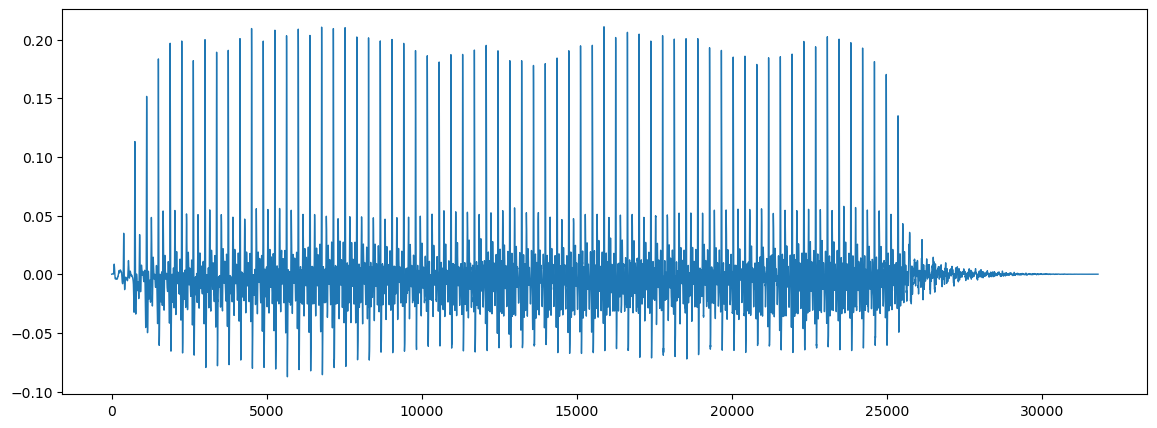

In [10]:
import librosa
import librosa.display
y, sr = librosa.load(filename)
pd.Series(y).plot(figsize=(14,5),lw=1)
plt.show()

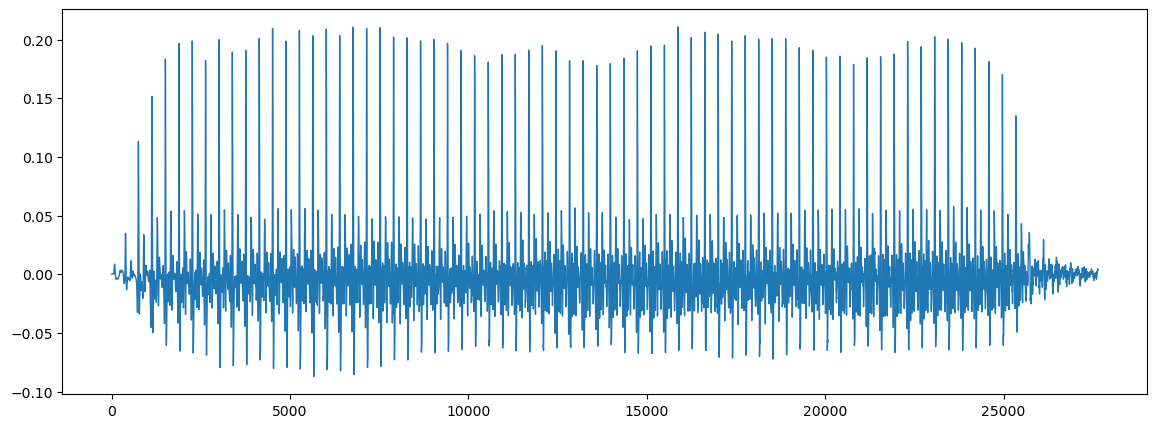

In [11]:
y_trimmed,_=librosa.effects.trim(y,top_db=20)
pd.Series(y_trimmed).plot(figsize=(14,5),lw=1)
plt.show()

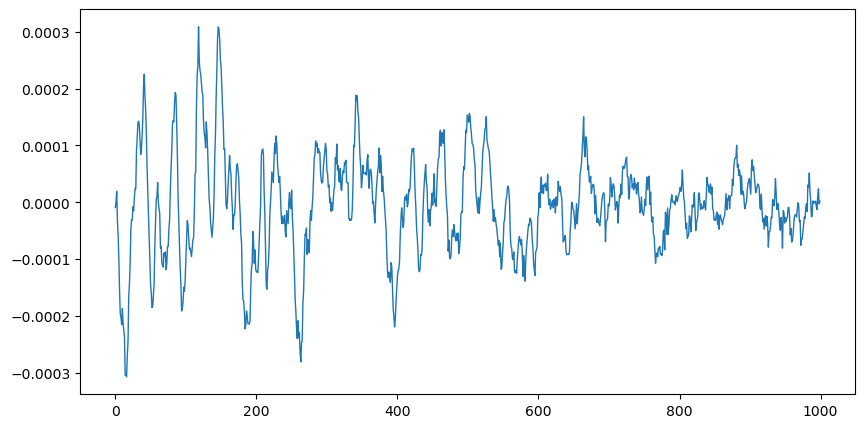

In [16]:
pd.Series(y[30000:31000]).plot(figsize=(10,5),lw=1)
plt.show()

In [17]:
### Check whether the dataset is imbalanced
df['Family'].value_counts()

Strings      1193
Keyboards     689
Winds         576
Brass         455
Name: Family, dtype: int64

In [18]:
df['Instrument (in full)'].value_counts()

Accordion         689
Contrabass        309
Viola             309
Cello             291
Violin            284
French Horn       134
Bassoon           126
Clarinet in Bb    126
Flute             118
Trombone          117
Bass Tuba         108
Oboe              107
Alto Saxophone     99
Trumpet in C       96
Name: Instrument (in full), dtype: int64

In [20]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
print(mfccs.shape)

(40, 63)


In [21]:
mfccs

array([[-5.7297791e+02, -4.8672510e+02, -4.2070508e+02, ...,
        -7.3365106e+02, -7.6884485e+02, -7.7732983e+02],
       [ 2.1990262e+02,  2.7114221e+02,  2.7934192e+02, ...,
         4.8704830e+01,  1.0880182e+01,  0.0000000e+00],
       [ 8.1922691e+01,  4.7260796e+01, -1.7334819e-02, ...,
         2.0962479e+01,  8.1664553e+00,  0.0000000e+00],
       ...,
       [-2.9308007e+00, -2.5611579e+00, -4.5762515e+00, ...,
        -2.9425867e+00, -3.1459801e+00,  0.0000000e+00],
       [-2.5378084e+00, -4.3805723e+00, -4.1605601e+00, ...,
        -2.1387906e+00, -2.4375505e+00,  0.0000000e+00],
       [-2.4865284e+00, -4.3173852e+00, -2.5056806e+00, ...,
        -1.9111506e+00, -2.0259104e+00,  0.0000000e+00]], dtype=float32)

In [48]:
root_directory = 'TinySOL'

In [49]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features  

In [50]:
from tqdm import tqdm
import os
for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(root_directory) + '/',str(row["Path"]))
    final_class_labels=row["Family"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

2913it [00:52, 55.26it/s]


In [51]:
features_df = pd.DataFrame(extracted_features, columns=['Features', 'Class'])
print(features_df.head())

                                            Features  Class
0  [-797.5747, 156.30415, 113.1748, 71.38083, 31....  Brass
1  [-782.1774, 157.00809, 112.38865, 68.23102, 26...  Brass
2  [-738.6921, 199.0998, 117.12333, 48.10994, 8.0...  Brass
3  [-781.1007, 157.59898, 111.65691, 66.03085, 23...  Brass
4  [-746.4353, 205.41095, 117.67022, 44.789036, 2...  Brass


In [104]:
X=np.array(features_df['Features'].tolist())
y=np.array(features_df['Class'].tolist())

In [105]:
X.shape

(2913, 40)

In [106]:
y

array(['Brass', 'Brass', 'Brass', ..., 'Winds', 'Winds', 'Winds'],
      dtype='<U9')

In [107]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [108]:
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [109]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [110]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train_scaled=sc.fit_transform(X_train)
X_test_scaled=sc.transform(X_test)

In [111]:
X_train

array([[-7.0285925e+02,  1.3996091e+02,  3.0487001e+01, ...,
        -2.8575122e+00,  1.3984938e-02, -2.4163210e+00],
       [-4.9842795e+02,  2.5425407e+01, -1.9925030e+01, ...,
         9.3818874e+00, -1.1118812e+01,  2.6689411e+01],
       [-5.9912305e+02,  1.0632105e+02,  1.8890196e+01, ...,
         9.4227018e+00, -1.3354563e+01, -1.5540654e+01],
       ...,
       [-3.5503522e+02,  1.3647729e+02,  3.3962674e+00, ...,
        -3.3670762e+00, -6.7236204e+00, -9.9842377e-02],
       [-5.6225836e+02,  1.0940611e+02, -7.1025482e+01, ...,
         2.9594337e+01,  5.2341553e+01,  5.5995628e+01],
       [-5.4820728e+02,  6.0165024e+01, -6.4186409e+01, ...,
        -3.2675920e+00,  5.1223361e-01, -2.6231838e+01]], dtype=float32)

In [112]:
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [113]:
y.shape

(2913, 4)

In [114]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(40, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

In [115]:
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

In [116]:
model.add(GlobalAveragePooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

In [117]:
model.add(Dense(4, activation='softmax'))

In [118]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [119]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 38, 64)            256       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 19, 64)            0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 19, 64)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 17, 128)           24704     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 8, 128)            0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 8, 128)           

In [123]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=None
)
X_train_scaled_reshaped = X_train_scaled.reshape(-1, 40, 1)
X_test_scaled_reshaped = X_test_scaled.reshape(-1, 40, 1)
train = model.fit(X_train_scaled_reshaped, y_train, batch_size=10, epochs=30, validation_split=0.2, callbacks=[callback])

Epoch 1/30
187/187 [==============================] - 0s 2ms/step - loss: 0.2346 - accuracy: 0.9158 - val_loss: 0.1818 - val_accuracy: 0.9249
Epoch 2/30
187/187 [==============================] - 0s 1ms/step - loss: 0.2339 - accuracy: 0.9115 - val_loss: 0.1335 - val_accuracy: 0.9614
Epoch 3/30
187/187 [==============================] - 0s 1ms/step - loss: 0.2022 - accuracy: 0.9260 - val_loss: 0.1320 - val_accuracy: 0.9678
Epoch 4/30
187/187 [==============================] - 0s 1ms/step - loss: 0.2344 - accuracy: 0.9190 - val_loss: 0.1534 - val_accuracy: 0.9528
Epoch 5/30
187/187 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy: 0.9254 - val_loss: 0.1431 - val_accuracy: 0.9485
Epoch 6/30
187/187 [==============================] - 0s 1ms/step - loss: 0.2126 - accuracy: 0.9222 - val_loss: 0.1355 - val_accuracy: 0.9571
Epoch 7/30
187/187 [==============================] - 0s 1ms/step - loss: 0.1981 - accuracy: 0.9190 - val_loss: 0.1317 - val_accuracy: 0.9592
Epoch 

In [124]:
evaluation = model.evaluate(X_test_scaled_reshaped, y_test)

19/19 [==============================] - 0s 1ms/step - loss: 0.1118 - accuracy: 0.9674


In [125]:
model.save("My_Model")

INFO:tensorflow:Assets written to: My_Model/assets


INFO:tensorflow:Assets written to: My_Model/assets


In [126]:
from tensorflow.keras.models import load_model
m = load_model("My_Model")

In [136]:
csv_file_path = "TinySOL_metadata.csv"
audio_folder_path = "TinySOL"

### 3. A general dataset

In [137]:
import torch
from torch.utils.data import Dataset
from tensorflow.keras.models import load_model

class AudioDataset(Dataset):
    def __init__(self, csv_file, audio_dir, model_path=None, scaler=None):
        self.audio_metadata = pd.read_csv(csv_file)
        self.audio_dir = audio_dir
        self.model = load_model(model_path) if model_path else None
        self.scaler = scaler

    def __len__(self):
        return len(self.audio_metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.audio_metadata.iloc[idx]
        audio_file = row['Path']  
        ground_truth = row['Family'] 
        file_path = f'{self.audio_dir}/{audio_file}'
        audio, sample_rate = librosa.load(file_path, sr=None)
        audio = audio[np.newaxis, :] 
        mel_spectrogram = librosa.feature.melspectrogram(y=audio.squeeze(), sr=sample_rate)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        mel_spectrogram = mel_spectrogram[np.newaxis, :]  
        pseudo_label = None
        if self.model:
            mfccs = librosa.feature.mfcc(y=audio.squeeze(), sr=sample_rate, n_mfcc=40)
            mfccs_scaled = self.scaler.transform(mfccs.T).T[np.newaxis, :, np.newaxis] if self.scaler else mfccs
            predictions = self.model.predict(mfccs_scaled)
            pseudo_label = np.argmax(predictions, axis=1)[0]

        sample = {
            'file': audio_file,
            'audio': audio,
            'mel': mel_spectrogram,
            'gt': ground_truth,
            'pseudo': pseudo_label
        }

        return sample


In [139]:
dataset=AudioDataset(csv_file_path,audio_folder_path)

In [140]:
dataset[0]

{'file': 'Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav',
 'audio': array([[0.0000000e+00, 3.0517578e-05, 0.0000000e+00, ..., 3.0517578e-05,
         0.0000000e+00, 0.0000000e+00]], dtype=float32),
 'mel': array([[[-42.417145, -41.07958 , -47.96993 , ..., -63.158764,
          -61.59269 , -64.192795],
         [-37.380486, -39.27009 , -38.171085, ..., -41.583767,
          -46.17336 , -52.751762],
         [-34.83998 , -32.37151 , -32.830063, ..., -37.53589 ,
          -41.414333, -49.42013 ],
         ...,
         [-83.87905 , -80.067764, -79.65316 , ..., -80.0992  ,
          -79.47728 , -81.45456 ],
         [-83.65414 , -79.65859 , -79.53929 , ..., -79.881905,
          -79.842896, -81.66683 ],
         [-84.21019 , -81.42562 , -79.55301 , ..., -81.124695,
          -80.89263 , -82.823494]]], dtype=float32),
 'gt': 'Brass',
 'pseudo': None}

### In order to improve the performance of the CNN in step-4 (other than increasing num_epochs in step-2), I will:

1. Enhance my dataset by introducing variations of the training samples through techniques such as time stretching, pitch shifting, or adding noise. This can make my model more robust and potentially improve performance.

2. Start training with samples that are easier to learn from (e.g., having higher confidence pseudo labels) and gradually introduce more difficult samples.

3. Experiment with different model architectures or adjust hyperparameters such as the learning rate. Using learning rate schedulers that adjust the learning rate during training can also be beneficial.

4. Train multiple models or use ensemble learning techniques to combine the strengths of various models, potentially improving overall performance.
